<a href="https://colab.research.google.com/github/hirru/GenAI/blob/main/Creating_chatbot_with_external_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!pip install langgraph langchain langsmith langchain_groq langchain_community

In [112]:
from typing import Annotated
from typing_extensions import TypedDict

In [113]:
!pip install arxiv wikipedia

In [114]:
## Working with tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and wikipedia tools

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [115]:
wiki_tool.invoke('Who is shahrukh khan')

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100'

In [116]:
arxiv_tool.invoke('Attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [117]:
tools = [wiki_tool]

In [118]:
## Langgraph Applications
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]


In [119]:
from langgraph.graph import StateGraph, START, END


In [120]:
graph_builder = StateGraph(State)

In [121]:
from langchain_groq import ChatGroq



In [122]:
from google.colab import userdata

groq_api_key = userdata.get('GROQ_API_KEY')


In [123]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it")

In [124]:
llm_with_tools = llm.bind_tools(tools=tools)

In [125]:
def chatbot(state:State):
  return {"messages": [llm_with_tools.invoke(state['messages'])]}


In [126]:
from langgraph.prebuilt import ToolNode, tools_condition

In [127]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [128]:
graph=graph_builder.compile()

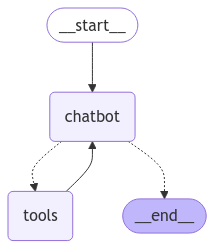

In [129]:
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  # This requires some extra dependencies and is optional
  print(e)

In [130]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_tp1f)
 Call ID: call_tp1f
  Args:
    query: John


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

Okay, I understand.  Maybe you could tell me what you'd like to know about John?
